In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]="6" #,1,2,3

In [2]:
import os 
import torch
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from os.path import join as pjoin
from torch.distributions import Categorical
import json
import clip

import options.option_transformer as option_trans
import models.vqvae as vqvae
import utils.utils_model as utils_model
import utils.eval_trans as eval_trans
from dataset import dataset_TM_train
from dataset import dataset_TM_eval
from dataset import dataset_tokenize
import models.t2m_trans_uplow as trans
from options.get_eval_option import get_opt
from models.evaluator_wrapper import EvaluatorModelWrapper
import warnings
warnings.filterwarnings('ignore')
from exit.utils import get_model, visualize_2motions, generate_src_mask, uniform, cosine_schedule
from einops import rearrange, repeat
import os
import torch.nn.functional as F
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
# os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

In [3]:
class Temp:
    def __init__(self):
        print('mock:: opt')
args = Temp()
args.dataname = args.dataset_name = 't2m'
args.down_t = 2

# train_loader_token = dataset_tokenize.DATALoader(args.dataname, 1, unit_length=2**args.down_t)

from utils.word_vectorizer import WordVectorizer
w_vectorizer = WordVectorizer('./glove', 'our_vab')
val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 32, w_vectorizer)

dataset_opt_path = 'checkpoints/kit/Comp_v6_KLD005/opt.txt' if args.dataname == 'kit' else 'checkpoints/t2m/Comp_v6_KLD005/opt.txt'

wrapper_opt = get_opt(dataset_opt_path, torch.device('cuda'))
eval_wrapper = EvaluatorModelWrapper(wrapper_opt)

mock:: opt


 17%|█▋        | 249/1460 [00:00<00:00, 2479.22it/s]

100%|██████████| 1460/1460 [00:00<00:00, 2657.30it/s]


Pointer Pointing at 0
Reading checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading Evaluation Model Wrapper (Epoch 28) Completed!!


In [4]:
##### ---- Network ---- #####
clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False)  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

# https://github.com/openai/CLIP/issues/111
class TextCLIP(torch.nn.Module):
    def __init__(self, model) :
        super(TextCLIP, self).__init__()
        self.model = model
        
    def forward(self,text):
        return self.model.encode_text(text)
clip_model = TextCLIP(clip_model)

In [5]:
args.nb_code = 8192 # 512 # 
args.code_dim = 32 # 512 # 
args.output_emb_width = 512
args.down_t = 2
args.stride_t = 2
args.width = 512
args.depth = 3
args.dilation_growth_rate = 3
args.vq_act = 'relu'
args.vq_norm = None
args.quantizer = 'ema_reset'
args.mu = 0.99
args.clip_dim = 512
args.block_size = 51
args.n_head_gpt = 16
args.drop_out_rate = 0.1
args.ff_rate = 4


######## LARGE ########
args.num_layers = 9
args.embed_dim_gpt = 1024
# args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/2023-09-19-23-09-12_HML3D_40_upperEdit_vqUpperLowerSep_transMaskLower/net_last.pth'
args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/t2m/2023-09-21-21-06-44_HML3D_41_upperEdit_transMaskLower_randLen/net_last.pth'
# args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/vq/2023-09-16-09-41-02_27_HML3D_upperLower_8192x32_shuffleIdx/net_last.pth'
args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/vq/2023-08-08-00-29-40_16_VQVAE_upperlower_notShareCB_20batchResetNRandom_8192x32/net_last.pth'
# args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/vq/2023-09-19-11-33-17_28_HML3D_upperLower_sepDecoder_512Upper512LowerEncDec_fixedSep/net_last.pth'

if args.dataset_name == 'kit':
    args.vq_name = 'VQVAE'
elif args.dataset_name == 't2m':
    args.vq_name = '2023-09-16-09-41-02_27_HML3D_upperLower_8192x32_shuffleIdx'


args.exp_name = 'TEMP'
args.out_dir = 'output_GPT_Final'
args.out_dir = os.path.join(args.out_dir, f'{args.exp_name}')
args.vq_dir= f'output/vq/{args.vq_name}'
codebook_dir = f'{args.vq_dir}/codebook/'
os.makedirs(args.out_dir, exist_ok = True)
os.makedirs(args.vq_dir, exist_ok = True)
os.makedirs(codebook_dir, exist_ok = True)

from models.vqvae_sep import VQVAE_SEP
net = VQVAE_SEP(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)
                    #    sep_decoder=True
class VQVAE_WRAPPER(torch.nn.Module):
    def __init__(self, vqvae) :
        super().__init__()
        self.vqvae = vqvae
        
    def forward(self, *args, **kwargs):
        return self.vqvae(*args, **kwargs)
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
# net = torch.nn.DataParallel(net)
net = VQVAE_WRAPPER(net)
    
trans_encoder = trans.Text2Motion_Transformer(net, 
                                    num_vq=args.nb_code, 
                                    embed_dim=args.embed_dim_gpt, 
                                    clip_dim=args.clip_dim, 
                                    block_size=args.block_size, 
                                    num_layers=args.num_layers, 
                                    n_head=args.n_head_gpt, 
                                    drop_out_rate=args.drop_out_rate, 
                                    fc_rate=args.ff_rate)



ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder = torch.nn.DataParallel(trans_encoder)
net.eval()
net.cuda()
trans_encoder.train()
trans_encoder.cuda()
''

''

In [6]:
if len(os.listdir(codebook_dir)) == 0:
    train_loader_token = dataset_tokenize.DATALoader(args.dataname, 1, unit_length=2**args.down_t)
    for batch in tqdm(train_loader_token):
        pose, name = batch
        bs, seq = pose.shape[0], pose.shape[1]

        pose = pose.cuda().float() # bs, nb_joints, joints_dim, seq_len
        target = net(pose, type='encode')
        target = target.cpu().numpy()
        np.save(pjoin(codebook_dir, name[0] +'.npy'), target)

In [7]:
args.batch_size = 2
num_workers = 1
train_loader = dataset_TM_train.DATALoader(args.dataname, args.batch_size, args.nb_code, codebook_dir, unit_length=2**args.down_t, num_workers=num_workers, up_low_sep=True)
train_loader_iter = dataset_TM_train.cycle(train_loader)

  0%|          | 0/23384 [00:00<?, ?it/s]

100%|██████████| 23384/23384 [00:06<00:00, 3758.58it/s]


In [9]:
args.pkeep = .5
batch = next(iter(train_loader))
clip_text, target, m_tokens_len = batch

In [9]:
batch_size, max_len = target.shape[:2]
target, m_tokens_len = target.cuda(), m_tokens_len.cuda()
bs = target.shape[0]

text = clip.tokenize(clip_text, truncate=True).cuda()

feat_clip_text = clip_model(text).float()
target_upper = target[..., 0]
target_lower = target[..., 1]

# [INFO] Swap input index
if args.pkeep == -1:
    proba = np.random.rand(1)[0]
    mask = torch.bernoulli(proba * torch.ones(target_upper.shape,
                                                        device=target.device))
else:
    mask = torch.bernoulli(args.pkeep * torch.ones(target_upper.shape,
                                                        device=target.device))
# random only motion token (not pad token). To prevent pad token got mixed up.
seq_mask_no_end = generate_src_mask(max_len, m_tokens_len)
mask = torch.logical_or(mask, ~seq_mask_no_end).int()
r_indices = torch.randint_like(target_upper, args.nb_code)
input_indices = mask*target_upper+(1-mask)*r_indices

In [14]:
# 1. Random replace by mask id
mask_id = get_model(net).vqvae.num_code + 2
proba = torch.randint(low=5, high=11, size=(target_lower.shape[0],))/10
proba = proba[:, None].cuda()
# torch.tensor([[0],[1]]).cuda()
mask_lower = torch.bernoulli(proba * torch.ones(target_lower.shape,
                                                        device=target.device))
mask_lower = torch.logical_or(mask_lower, ~seq_mask_no_end).int()
r_indices_lower = torch.randint_like(target_lower, args.nb_code)
input_indices_lower = mask_lower*target_lower+(1-mask_lower)*mask_id
# input_indices_lower == 8194, proba, (1-mask_lower).sum(-1)/50

proba_txt = torch.randint(low=5, high=11, size=(target_lower.shape[0],))/10
proba_txt = proba_txt[:, None].cuda()
txt_mark = torch.bernoulli(proba_txt * torch.ones(target_lower.shape, device=target.device))
# txt_mark = torch.logical_or(txt_mark, ~seq_mask_no_end).int()
txt_mark, proba_txt

(tensor([[0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
          0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
          1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
          0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.]],
        device='cuda:0'),
 tensor([[0.7000],
         [0.5000]], device='cuda:0'))

In [46]:
# 2. random replace by random index
import random
proba = random.randint(0, 2)/10
mask_lower = torch.bernoulli(proba * torch.ones(target_lower.shape,
                                                        device=target.device))
mask_lower = torch.logical_or(mask_lower, ~seq_mask_no_end).int()
r_indices_lower = torch.randint_like(target_lower, args.nb_code)
input_indices_lower = mask_lower*target_upper+(1-mask_lower)*r_indices_lower

In [15]:
# Time step masking
mask_id = get_model(net).vqvae.num_code + 2
# rand_time = uniform((batch_size,), device = target.device)
# rand_mask_probs = cosine_schedule(rand_time)
rand_mask_probs = torch.zeros(batch_size, device = m_tokens_len.device).float().uniform_(0.5, 1)
num_token_masked = (m_tokens_len * rand_mask_probs).round().clamp(min = 1)
seq_mask = generate_src_mask(max_len, m_tokens_len+1)
batch_randperm = torch.rand((batch_size, max_len), device = target.device) - seq_mask_no_end.int()
batch_randperm = batch_randperm.argsort(dim = -1)
mask_token = batch_randperm < rearrange(num_token_masked, 'b -> b 1')

# masked_target = torch.where(mask_token, input=input_indices, other=-1)
masked_input_indices = torch.where(mask_token, mask_id, input_indices)



In [16]:
att_txt = None #proba != 1 # CFG: torch.rand((seq_mask.shape[0], 1)) > 0.1
cls_pred = trans_encoder(masked_input_indices, input_indices_lower, feat_clip_text, src_mask = seq_mask, att_txt=att_txt, txt_mark=txt_mark)[:, 1:]

In [15]:
# [INFO] Compute xent loss as a batch
weights = seq_mask_no_end / (seq_mask_no_end.sum(-1).unsqueeze(-1) * seq_mask_no_end.shape[0])
cls_pred_seq_masked = cls_pred[seq_mask_no_end, :].view(-1, cls_pred.shape[-1])
target_seq_masked = target_upper[seq_mask_no_end]
weight_seq_masked = weights[seq_mask_no_end]
loss_cls = F.cross_entropy(cls_pred_seq_masked, target_seq_masked, reduction = 'none')
loss_cls = (loss_cls * weight_seq_masked).sum()

### Net Sep Encoder/Decoder

In [40]:
net = VQVAE_SEP(args, ## use args to define different parameters in different quantizers
                args.nb_code,
                args.code_dim,
                args.output_emb_width,
                args.down_t,
                args.stride_t,
                args.width,
                args.depth,
                args.dilation_growth_rate,
                sep_decoder=True)
net = VQVAE_WRAPPER(net)
net.eval()
net.cuda()
''

''

### Eval

In [37]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, True, 32, w_vectorizer)

100%|██████████| 4384/4384 [00:02<00:00, 1799.21it/s]

Pointer Pointing at 0


In [49]:
class LoggerWriterMock:
    def __init__(self):
        self.info
    def info(self, *args):
        print(*args)
    def add_scalar(self, *args):
        print(*args)
    def add_video(self, *args):
        print(*args)
logger = LoggerWriterMock()
logger.info('test')
writer = LoggerWriterMock()
writer.add_scalar('./Test/FID', 'fid', 'nb_iter')

test
./Test/FID fid nb_iter


In [50]:
########## Test Single Sample ##########
# word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name = next(iter(val_loader))
# seq = pose.shape[1]
# m_length = m_length.cuda()
m_length = torch.tensor([180, 54]).cuda() # length: [196, 54]
m_tokens_len = torch.ceil((m_length)/4)
feat_clip_text = torch.rand([2, 512]) # [2, 512]
feat_clip_text = feat_clip_text.cuda()

target_lower = torch.randint(0, 8192, [2, 50])
seq_mask_no_end = generate_src_mask(max_len, m_tokens_len)
target_lower[~seq_mask_no_end] = 8193
target_lower = target_lower.cuda()
target_lower.scatter_(dim=-1, index=m_tokens_len[:, None].long(), value=8192)

import timeit
total = 0
num_all = 0
blank_id = get_model(trans_encoder).num_vq
for k in range(1):
    start = timeit.default_timer()
    index_motion, temp = trans_encoder(feat_clip_text, target_lower, type="sample", m_length=m_length, if_test=True, CFG=-1)
    index_motion = torch.cat((index_motion[..., None], target_lower[..., None]), dim=-1)
    pred_pose = net(index_motion[k:k+1, :int(m_tokens_len[k].item())], type='decode')

    stop = timeit.default_timer()
    total += (stop - start)
    num_all += 1
total/num_all


0.4178908709436655

In [ ]:
pred_pose_eval, pose, m_length, clip_text, best_fid, best_iter, best_div, best_top1, best_top2, best_top3, best_matching, best_multi, writer, logger = \
    eval_trans.evaluation_transformer_uplow(args.out_dir, 
        val_loader, 
        net, 
        trans_encoder, 
        logger, 
        writer, 
        0, 
        best_fid=1000, 
        best_iter=0, 
        best_div=100, 
        best_top1=0, 
        best_top2=0, 
        best_top3=0, 
        best_matching=100, 
        clip_model=clip_model, 
        dataname=args.dataname,
        eval_wrapper=eval_wrapper,
        num_repeat=1,
        rand_pos=True,
        CFG=-1)

### Visualization

In [8]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, True, 32, w_vectorizer)

  0%|          | 0/4384 [00:00<?, ?it/s]

100%|██████████| 4384/4384 [00:01<00:00, 3085.36it/s]

Pointer Pointing at 0


In [9]:
__break__ = False
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name in val_loader:
    for i, lower_text in enumerate(clip_text):
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in lower_text:
        # if 'a man throws a ball.' in lower_text:
        if 'a man rises from the ground, walks in a circle and sits back down on the ground.' in lower_text:
        # if 'a person walks backwards, turns around and walks backwards the other way.' in lower_text:
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in lower_text:
            __break__ = True
            print(lower_text)
            break
    if __break__:
        break

a man rises from the ground, walks in a circle and sits back down on the ground.


In [19]:
# __upper_text__ = ['person takes one step and uses the left arm to do an uppercut boxing punch'] * 32
# __upper_text__ = ['a man throws a ball.'] * 32
# __upper_text__ = ['a man rises from the ground, walks in a circle and sits back down on the ground.'] * 32
# __upper_text__ = ['a person walks backwards, turns around and walks backwards the other way.'] * 32
__upper_text__ = ['A person punches with right hand'] * 32
# __upper_text__ = ['person takes one step and uses the left arm to do an uppercut boxing punch'] * 32

In [53]:
pose = pose.cuda().float() # bs, nb_joints, joints_dim, seq_len
m_tokens_len = torch.ceil((m_length)/4)
bs, seq = pose.shape[:2]
max_motion_length = int(seq/4) + 1
mot_end_idx = get_model(net).vqvae.num_code
mot_pad_idx = get_model(net).vqvae.num_code + 1
target_lower = []
for k in range(bs):
    target = net(pose[k:k+1, :m_length[k]], type='encode')
    if m_tokens_len[k]+1 < max_motion_length:
        target = torch.cat([target, 
                            torch.ones((1, 1, 2), dtype=int, device=target.device) * mot_end_idx, 
                            torch.ones((1, max_motion_length-1-m_tokens_len[k].int().item(), 2), dtype=int, device=target.device) * mot_pad_idx], axis=1)
    else:
        target = torch.cat([target, 
                            torch.ones((1, 1, 2), dtype=int, device=target.device) * mot_end_idx], axis=1)
    target_lower.append(target[..., 1])
target_lower = torch.cat(target_lower, axis=0)

# mask lower body
end_id = get_model(net).vqvae.num_code
mask_id = get_model(net).vqvae.num_code + 2
target_lower_masked = target_lower.clone()
# target_lower_masked[target_lower < end_id] = mask_id
target_lower_masked[i, 20:42] = mask_id
target_lower_masked[i]

tensor([2426, 5568, 1595, 3702, 2727, 5012, 3567, 8082,  267, 2041, 6808, 4165,
        5467, 1312, 8023, 4539, 4107, 1660, 3971, 8045, 8194, 8194, 8194, 8194,
        8194, 8194, 8194, 8194, 8194, 8194, 8194, 8194, 8194, 8194, 8194, 8194,
        8194, 8194, 8194, 8194, 8194, 8194, 2612, 6929, 4707, 4707, 4707, 1768,
        1768, 8192], device='cuda:0')

In [54]:
pred_len = m_length.cuda()
pred_tok_len = m_tokens_len
pred_pose_eval = torch.zeros((bs, seq, pose.shape[-1])).cuda()

text = clip.tokenize(__upper_text__, truncate=True).cuda()
feat_clip_text = clip_model(text).float()
index_motion = trans_encoder(feat_clip_text, target_lower_masked, type="sample", m_length=pred_len, rand_pos=True, CFG=-1)
# for k in range(bs):
all_tokens = torch.cat([
    index_motion[i:i+1, :int(pred_tok_len[i].item()), None],
    target_lower[i:i+1, :int(pred_tok_len[i].item()), None]
], axis=-1)
pred_pose = net(all_tokens, type='decode')
pred_pose_eval[i:i+1, :int(pred_len[i].item())] = pred_pose

In [55]:
x = pose[i].detach().cpu().numpy()
y = pred_pose_eval[i].detach().cpu().numpy()
l = m_length[i]
caption = clip_text[i]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, args.dataname, l, y, save_path=None)

In [ ]:
x.shape, y.shape

((196, 263), (56, 263))

### Visualize Up Low Different

In [19]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, True, 32, w_vectorizer)

  0%|          | 0/4384 [00:00<?, ?it/s]

100%|██████████| 4384/4384 [00:01<00:00, 2494.56it/s]

Pointer Pointing at 0


In [56]:
__break__ = False
for word_embeddings1, pos_one_hots1, clip_text1, sent_len1, pose1, m_length1, token1, name1 in val_loader:
    for i, text1 in enumerate(clip_text1):
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in text1:
        if 'a man throws a ball.' in text1:
        # if 'a man rises from the ground, walks in a circle and sits back down on the ground.' in text1:
        # if 'a person walks backwards, turns around and walks backwards the other way.' in text1:
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in text1:
            __break__ = True
            print(text1)
            break
    if __break__:
        break

a man throws a ball.


In [93]:
__break__ = False
for word_embeddings2, pos_one_hots2, clip_text2, sent_len, pose2, m_length2, token2, name2 in val_loader:
    for j, text2 in enumerate(clip_text2):
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in text2:
        # if 'a man throws a ball.' in text2:
        if 'a man rises from the ground, walks in a circle and sits back down on the ground.' in text2:
        # if 'a person walks backwards, turns around and walks backwards the other way.' in text2:
        # if 'person takes one step and uses the left arm to do an uppercut boxing punch' in text2:
            __break__ = True
            print(text2)
            break
    if __break__:
        break

a man rises from the ground, walks in a circle and sits back down on the ground.


In [23]:
mot_end_idx = get_model(net).vqvae.num_code
mot_pad_idx = get_model(net).vqvae.num_code + 1

In [24]:
### Mixing in Laten Space
upper_idx = net(pose1[i:i+1, :m_length1[i]].cuda(), type='encode')
lower_idx = net(pose2[j:j+1, :m_length2[j]].cuda(), type='encode')
upper_idx = torch.cat((upper_idx, upper_idx, upper_idx, upper_idx, upper_idx, upper_idx), dim=1)
upper_idx.shape, lower_idx.shape
target = torch.cat([upper_idx[:, :lower_idx.shape[1], :1], lower_idx[..., 1:]], dim=-1)

bs, seq = pose2.shape[:2]
pred_pose_eval = torch.zeros((1, seq, pose2.shape[-1])).cuda()
pred_pose = net(target, type='decode')
pred_pose_eval[:1, :int(m_length2[j].item())] = pred_pose

In [111]:
### Mixing in Pixel Space
bs, seq = pose2.shape[:2]
pred_pose_eval = torch.zeros((1, seq, pose2.shape[-1]))
pose_up = pose1[i:i+1, :int(m_length1[i].item())]
pose_up = torch.cat([pose_up, pose_up, pose_up, pose_up, pose_up, pose_up], axis=1)

from utils.humanml_utils import HML_UPPER_BODY_MASK, HML_LOWER_BODY_MASK
from models.vqvae_sep import get_part_mask
pose_up = get_part_mask(HML_UPPER_BODY_MASK, pose_up)
pose_down = get_part_mask(HML_LOWER_BODY_MASK, pose2)

# pred_pose_eval[:1, :int(m_length2[j].item())] = pose2[j:j+1, :int(m_length2[j].item())]
pred_pose_eval[:1, :int(m_length2[j].item()), HML_UPPER_BODY_MASK] = pose_up[:1, :int(m_length2[j].item())].float()
pred_pose_eval[:1, :int(m_length2[j].item()), HML_LOWER_BODY_MASK] = pose_down[j:j+1, :int(m_length2[j].item())].float()

In [112]:
x = pose2[j].detach().cpu().numpy()
y = pred_pose_eval[0].detach().cpu().numpy()
l = m_length2[j]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, args.dataname, l, y, save_path=None)

### Plot Length in Bins

In [16]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 32, w_vectorizer)

  0%|          | 0/1460 [00:00<?, ?it/s]

100%|██████████| 1460/1460 [00:00<00:00, 2712.14it/s]

Pointer Pointing at 0


(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  20,   9,  11,
         28,  31,  39,  33,  37,  24,  31,  42,  27,  26,  14,  34,  39,
         28,  37,  19,  19,  30,  16,  19,  26,  22,  28,  19,  18,  15,
         22,  31,  19,  20,  16,  27,  24,  25,   7, 570]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

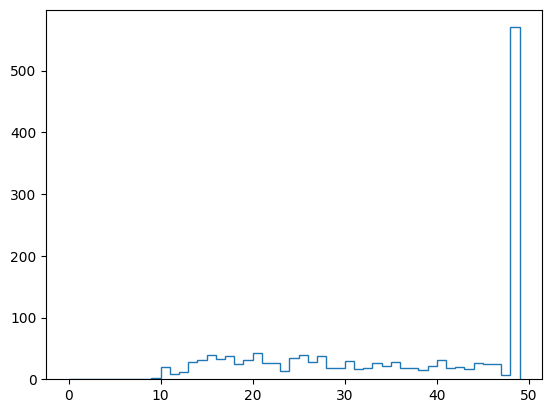

In [17]:
all_len = []
# for clip_text, target, m_tokens_len in train_loader:
#     for clip_text, target, m_tokens_len in train_loader:
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_tokens_len, token, name in val_loader:
    all_len.append(m_tokens_len)
all_len
a = (torch.cat(all_len)/4).numpy()
counts, bins = np.histogram(a, bins = np.arange(50))
plt.stairs(counts, bins)
counts, bins